In [189]:
import numpy as np
import pandas as pd 
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [190]:
df_small_noise =pd.read_csv('data2.csv',usecols=['doc_count'])

df_daily_jumpsup =pd.read_csv('test2.csv',usecols=['doc_count'])


print(df_daily_jumpsup.iloc[535])

doc_count    19
Name: 535, dtype: int64


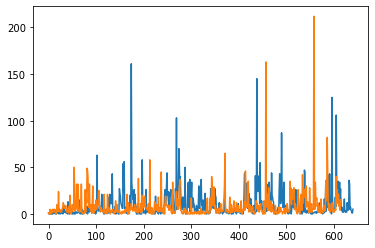

In [191]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax= ax)
df_daily_jumpsup.plot(legend=False, ax= ax)
plt.show()

In [192]:
#prepare training data:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean)/ training_std
print("Number of training samples: ", len(df_training_value))

Number of training samples:  641


In [193]:
TIME_STEPS = 24

#create sequences combining time_steps contiguous data values from the training data
def create_sequences(values, time_steps= TIME_STEPS):
    output = []
    for i in range(len(values)-time_steps):
        output.append(values[i: (i+time_steps)])
    return np.stack(output)

x_train = create_sequences(df_training_value.values)
print(">T<raining input shape: ", x_train.shape)


>T<raining input shape:  (617, 24, 1)


In [194]:
#build model
model = keras.Sequential(
[
    layers.Input(
        shape=(x_train.shape[1], x_train.shape[2])),
                layers.Conv1D(
                filters=32, 
                    kernel_size=7, 
                    padding="same",
                    strides=2, 
                    activation="relu"),
                layers.Dropout(rate=0.2),
                layers.Conv1D(
                filters=16, kernel_size=7,
                padding="same", strides=2,
                activation="relu"),
                layers.Conv1DTranspose(
                    filters=16,
                    kernel_size=7,
                    padding="same",
                    strides=2,
                    activation="relu"
                ),
                layers.Dropout(rate=0.2),
                layers.Conv1DTranspose(
                filters=32,kernel_size=7, 
                padding="same", strides=2,activation="relu"),
                layers.Conv1DTranspose(filters=1,kernel_size=7, padding="same"),
                
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 12, 32)            256       
_________________________________________________________________
dropout_34 (Dropout)         (None, 12, 32)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 6, 16)             3600      
_________________________________________________________________
conv1d_transpose_51 (Conv1DT (None, 12, 16)            1808      
_________________________________________________________________
dropout_35 (Dropout)         (None, 12, 16)            0         
_________________________________________________________________
conv1d_transpose_52 (Conv1DT (None, 24, 32)            3616      
_________________________________________________________________
conv1d_transpose_53 (Conv1DT (None, 24, 1)           

In [195]:
#train the model
history = model.fit(
x_train,
x_train,
epochs=50,
batch_size=128,
validation_split=0.1,
callbacks=[
    keras.callbacks.EarlyStopping(monitor="loss", patience=5, mode="min")
],)

Epoch 1/50
5/5 [==============================] - 0s 76ms/step - loss: 0.9031 - val_loss: 1.8303
Epoch 2/50
5/5 [==============================] - 0s 10ms/step - loss: 0.8498 - val_loss: 1.6716
Epoch 3/50
5/5 [==============================] - 0s 11ms/step - loss: 0.7700 - val_loss: 1.5197
Epoch 4/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6960 - val_loss: 1.4503
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6215 - val_loss: 1.3254
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 0.5571 - val_loss: 1.1984
Epoch 7/50
5/5 [==============================] - 0s 11ms/step - loss: 0.4950 - val_loss: 1.0516
Epoch 8/50
5/5 [==============================] - 0s 12ms/step - loss: 0.4422 - val_loss: 0.9138
Epoch 9/50
5/5 [==============================] - 0s 11ms/step - loss: 0.3852 - val_loss: 0.7699
Epoch 10/50
5/5 [==============================] - 0s 12ms/step - loss: 0.3550 - val_loss: 0.6738
Epoch 11/50
5/5 [============

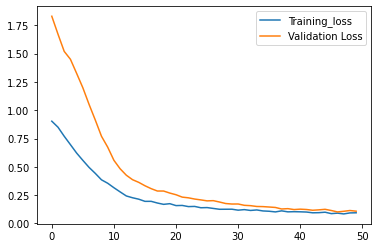

In [196]:
plt.plot(history.history["loss"],label= "Training_loss")
plt.plot(history.history["val_loss"], label= "Validation Loss")
plt.legend()
plt.show()

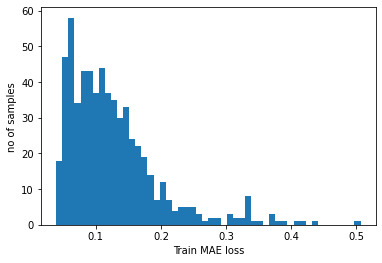

Reconstruction error threshold:  0.5066909835559558


In [197]:
#Detecting anomalies:
# We will detect anomalies by determining how well our model can reconstruct the input data

#find mean absolute error  : mae 
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred -x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("no of samples")
plt.show()

#get max mae that s our threshhold
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

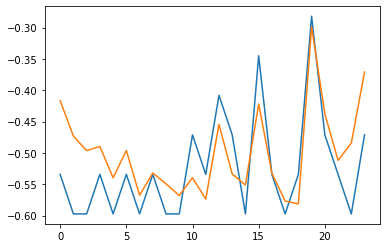

In [198]:
# Compare reconstruction :

plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

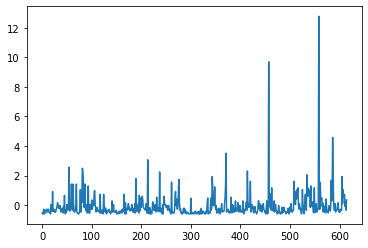

Test input shape:  (591, 24, 1)


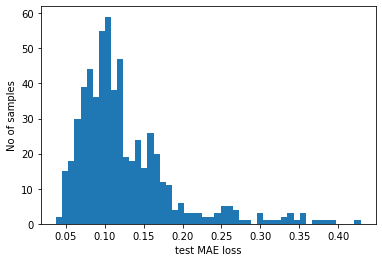

number of anomaly samples:  0
Indices of anomaly samples  (array([], dtype=int64),)


In [199]:
#Prepare test data:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values

df_test_value = (df_daily_jumpsup - training_mean) /training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show ()

# create sequences from test values
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

#Get test mae loss
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred- x_test),axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies
anomalies = test_mae_loss > threshold
print("number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples ", np.where(anomalies))


In [203]:
#data i is an anomaly if samples [(i - timesteps +1 to (i))] are anomalies
anomalous_data_indices  =  []
for data_idx in range (TIME_STEPS - 1, len(df_test_value)- TIME_STEPS +1 ):
    if np.all(anomalies[data_idx - TIME_STEPS+1 : data_idx]):
        anomalous_data_indices.append(data_idx)
print(anomalous_data_indices)

[]


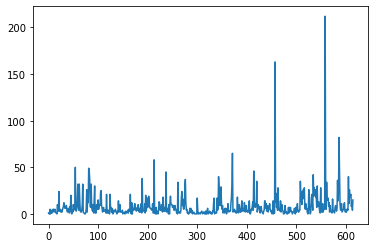

In [204]:
df_subset =  df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend= False, ax = ax)
df_subset.plot(legend= False, ax= ax, color= "r")
plt.show()